In [97]:
import scipy as scp
import scipy.sparse
import scipy.sparse.linalg
from scipy.linalg import expm
from scipy.sparse import csr_array

from scipy.integrate import solve_ivp
from scipy.optimize import fmin
import matplotlib.pyplot as plt
import numpy as np

import functools # for functools.reduce
from tqdm import tqdm
import os

# Tools


In [98]:
def exp_mat(M) :
    '''
    Computes the matrix exponential exp(M)
    
    Parameters
    ----------
    M : csr_array
        matrix

    Return
    ------
    exp(M) : csr_array
    '''
    return scp.sparse.csr_array(expm(M.toarray()))

# Spin operators


In [99]:
sx = 1/2 * scipy.sparse.csr_array([[0.,  1.],[1., 0.]])
sy = 1/2 * scipy.sparse.csr_array([[0., -1.j],[1.j, 0.]])
sz = 1/2 * scipy.sparse.csr_array([[1., 0.],[0., -1.]])

I = scipy.sparse.identity(2)

sp = ((sx + 1.j * sy) / 2).real
sm = ((sx - 1.j * sy) / 2).real

$$
\hat{\sigma}^{z}_{j} = \underbrace{\hat{I}\otimes\hat{I}\dots\hat{I}}_{j-1\ \mathrm{terms}}\otimes\hat{\sigma}^{z}\otimes\underbrace{\hat{I}\otimes\hat{I}\dots\otimes\hat{I}}_{N-j\ \mathrm{terms}},
$$


In [100]:
def sx_j(j, N):
    """
    Compute the operator $X_j$ acting on a N-spin system.
    
    Parameters
    ----------
    j : int
        The index of the spin to act on.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The operator $X_j$.
    """
    return functools.reduce(scipy.sparse.kron, [I] * (j - 1) + [sx] + [I] * (N - j))


def sy_j(j, N):
    """
    Compute the operator $Y_j$ acting on a N-spin system.
    
    Parameters
    ----------
    j : int
        The index of the spin to act on.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The operator $Y_j$.
    """
    return functools.reduce(scipy.sparse.kron, [I] * (j - 1) + [sy] + [I] * (N - j))


def sz_j(j, N):
    """
    Compute the operator $Z_j$ acting on a N-spin system.
    
    Parameters
    ----------
    j : int
        The index of the spin to act on.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The operator $Z_j$.
    """
    return functools.reduce(scipy.sparse.kron, [I] * (j - 1) + [sz] + [I] * (N - j))


def sp_j(j, N):
    """
    Compute the operator $S^+_j$ acting on a N-spin system.
    
    Parameters
    ----------
    j : int
        The index of the spin to act on.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The operator $S^+_j$.
    """
    return functools.reduce(scipy.sparse.kron, [I] * (j - 1) + [sp] + [I] * (N - j))


def sm_j(j, N):
    """
    Compute the operator $S^-_j$ acting on a N-spin system.
    
    Parameters
    ----------
    j : int
        The index of the spin to act on.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The operator $S^-_j$.
    """
    return functools.reduce(scipy.sparse.kron, [I] * (j - 1) + [sm] + [I] * (N - j))


def write_spin_operators(N) :
    path = f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}'
    os.makedirs(path, exist_ok=True)
    for k in range(1, N+1) :
        s = sx_j(k, N)
        scp.sparse.save_npz(path + f'/sx_k_{k}', s)

        s = sy_j(k, N)
        scp.sparse.save_npz(path + f'/sy_k_{k}', s)

        s = sz_j(k, N)
        scp.sparse.save_npz(path + f'/sz_k_{k}', s)

        s = sp_j(k, N)
        scp.sparse.save_npz(path + f'/sp_k_{k}', s)

        s = sm_j(k, N)
        scp.sparse.save_npz(path + f'/sm_k_{k}', s)


N = 8
write_spin_operators(N)


# Hamiltonian


In [101]:
def H_spin(N, J):
    """
    Compute the Hamiltonian of an N-spin system with nearest-neighbor interactions.

    Parameters
    ----------
    N : int
        The number of spins in the system.
    J : float
        The coupling constant.

    Returns
    -------
    scipy.sparse.csr_matrix
        The Hamiltonian of the system.
    """
    H = 0

    for i in range(1, N+1):
        if i == N:
            ip1 = 1
        else:
            ip1 = i + 1
        H += J * (sx_j(i, N) @ sx_j(ip1, N) + sy_j(i, N) @ sy_j(ip1, N) + sz_j(i, N) @ sz_j(ip1, N))

    return H

N = 2
J= 1

H = H_spin(N, J)
H.toarray()

array([[ 0.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j, -0.5+0.j,  1. +0.j,  0. +0.j],
       [ 0. +0.j,  1. +0.j, -0.5+0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j,  0.5+0.j]])

# Lindbladian


Lindblad operators for the 2nd dissipator:


In [116]:
def get_Lks(N) :
    """
    Compute the L_k operators for a N-spin system (2nd dissipator).

    Parameters
    ----------
    N : int
        The number of spins in the system.

    Returns
    -------
    list of scipy.sparse.csr_matrix
        The L_k operators.

    Note
    ----
    The L_k operators are indexed from 1 to N: get_Lks(N)[k] corresponds to L_k,
    and get_Lks(N)[0] is a dummy value to have the same indexing as in the paper.
    """

    Lks = [None]   # in order to have the same indexing as in the paper: from 1 to N

    for k in tqdm(range(1, N+1)) :
        kp1 = (k + 1) % N
        kp2 = (k + 2) % N

        if kp1 == 0:
            kp1 = N
        if kp2 == 0:
            kp2 = N

        sp_k = sp_j(k, N)
        sm_kp1 = sm_j(kp1, N)
        sp_kp2 = sp_j(kp2, N)

        Lk = 1/2 * (sp_k @ sm_kp1 + 1j * sm_kp1 @ sp_kp2)
        Lks.append(Lk)

    return Lks



def write_Lk_operators(N) :
    path = f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}'
    for k in tqdm(range(1, N+1)) :
        kp1 = (k + 1) % N
        kp2 = (k + 2) % N

        if kp1 == 0:
            kp1 = N
        if kp2 == 0:
            kp2 = N

        sp_k = scp.sparse.load_npz(path + f'/sp_k_{k}.npz')
        sm_kp1 = scp.sparse.load_npz(path + f'/sm_k_{kp1}.npz')
        sp_kp2 = scp.sparse.load_npz(path + f'/sp_k_{kp2}.npz')

        Lk = 1/2 * (sp_k @ sm_kp1 + 1j * sm_kp1 @ sp_kp2)
        scp.sparse.save_npz(path + f'/Lk_{k}', Lk)



N = 2
write_Lk_operators(N)
# Lks = get_Lks(N)
# Lks


100%|██████████| 2/2 [00:00<00:00, 124.95it/s]


write N=14


In [47]:
# write all operators

# N = 14
# write_spin_operators(N) # 10 min for N=14
# write_Lk_operators(N) # 1h30 for N=14, already done from 1 to 5

check get_Lks and write_Lk give same results


In [8]:
# N = 8
# write_Lk_operators(N)
# Lks = get_Lks(N)

# for k in range(1, N+1) :
#     Lk = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/Lk_{k}.npz')
#     assert scp.sparse.linalg.norm(Lk - Lks[k]) == 0

100%|██████████| 8/8 [00:00<00:00, 115.86it/s]


Dissipators:


In [118]:
def dissipator_1(rho, J, N) :
    """
    Compute the 1st dissipator of an N-spin system with nearest-neighbor interactions.

    Parameters
    ----------
    rho : scipy.sparse.csr_matrix
        The density matrix of the system.
    J : float
        The coupling constant.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The 1st dissipator of the system.
    """
    path = f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}'
    D = 0
    for k in range(1, N+1) :
        sz_k = scp.sparse.load_npz(path + f'/sz_k_{k}.npz')
        D += J * (sz_k @ rho @ sz_k - 0.5 * (sz_k @ sz_k @ rho + rho @ sz_k @ sz_k))
    return D


def dissipator_2(rho, J, N) :
    """
    Compute the 2nd dissipator of an N-spin system with nearest-neighbor interactions.

    Parameters
    ----------
    rho : scipy.sparse.csr_matrix
        The density matrix of the system.
    J : float
        The coupling constant.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The 2nd dissipator of the system.
    """
    path = f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}'
    D = 0
    for k in range(1, N+1) :
        Lk = scp.sparse.load_npz(path + f'/Lk_{k}.npz')
        D += J * (Lk @ rho @ Lk.H - 0.5 * (Lk.H @ Lk @ rho + rho @ Lk.H @ Lk))
    return D


rho_test = scipy.sparse.identity(2**N)
dissipator_1(rho_test, J, N), dissipator_2(rho_test, J, N)



(<4x4 sparse matrix of type '<class 'numpy.float64'>'
 	with 0 stored elements (blocksize = 2x2) in Block Sparse Row format>,
 <4x4 sparse matrix of type '<class 'numpy.complex128'>'
 	with 0 stored elements (blocksize = 2x2) in Block Sparse Row format>)

Lindbladian


In [119]:
def lindblad_non_unitary(rho, epsilon, gamma, J, N) :
    """
    Compute the non-unitary part of the Lindblad equation of an N-spin system with nearest-neighbor interactions.

    Parameters
    ----------
    rho : scipy.sparse.csr_matrix
        The density matrix of the system.
    epsilon : float
        The perturbation strength.
    gamma : float
        The relative strength.
    J : float
        The coupling constant.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The non-unitary part of the Lindbladian of the system.
    """
    L1 = epsilon * (gamma * dissipator_1(rho, J, N) + (1 - gamma) * dissipator_2(rho, J, N))
    return L1 


def lindblad(rho, H, epsilon, gamma, J, N) :
    """
    Compute the Lindblad equation of an N-spin system with nearest-neighbor interactions.

    Parameters
    ----------
    rho : scipy.sparse.csr_matrix
        The density matrix of the system.
    H : scipy.sparse.csr_matrix
        The Hamiltonian of the system.
    epsilon : float
        The perturbation strength.
    gamma : float
        The relative strength.
    J : float
        The coupling constant.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The Lindbladian of the system.
    """
    L0 = - 1j * (H @ rho - rho @ H)
    L1 = lindblad_non_unitary(rho, epsilon, gamma, J, N)
    return L0 + L1 


EPSILON = 0.1
GAMMA = 0.5
lindblad(rho_test, H_spin(N, J), EPSILON, GAMMA, J, N)

<4x4 sparse matrix of type '<class 'numpy.complex128'>'
	with 0 stored elements (blocksize = 2x1) in Block Sparse Row format>

# Quantities useful to define Conserved quantities


In [122]:
def Ob(N) :
    """
    Boost operator

    Parameters
    ----------
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The boost operator.
    """
    path = f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}'
    O = 0


    for i in range(1, N+1):
        if i == N:
            ip1 = 1
        else:
            ip1 = i + 1

        sx_i = scp.sparse.load_npz(path + f'/sx_k_{i}.npz')
        sx_ip1 = scp.sparse.load_npz(path + f'/sx_k_{ip1}.npz')

        sy_i = scp.sparse.load_npz(path + f'/sy_k_{i}.npz')
        sy_ip1 = scp.sparse.load_npz(path + f'/sy_k_{ip1}.npz')

        sz_i = scp.sparse.load_npz(path + f'/sz_k_{i}.npz')
        sz_ip1 = scp.sparse.load_npz(path + f'/sz_k_{ip1}.npz')

        O += -1j * i * (sx_i @ sx_ip1 + sy_i @ sy_ip1 + sz_i @ sz_ip1)

    return O


Ob(N)



<4x4 sparse matrix of type '<class 'numpy.complex128'>'
	with 16 stored elements (blocksize = 2x2) in Block Sparse Row format>

In [128]:
def Jh(N, J) :
    """
    Compute the heat current operator of an N-spin system with nearest-neighbor interactions.

    Parameters
    ----------
    N : int
        The number of spins in the system.
    J : float
        The coupling constant.

    Returns
    -------
    float
        The value of the JH operator.
    """
    path = f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}'
    JH = 0

    for k in range(1, N+1) :
        kp1 = (k + 1) % N
        kp2 = (k + 2) % N

        if kp1 == 0:
            kp1 = N
        if kp2 == 0:
            kp2 = N

        sx_k = scp.sparse.load_npz(path + f'/sx_k_{k}.npz')
        sx_kp1 = scp.sparse.load_npz(path + f'/sx_k_{kp1}.npz')
        sx_kp2 = scp.sparse.load_npz(path + f'/sx_k_{kp2}.npz')

        sy_k = scp.sparse.load_npz(path + f'/sy_k_{k}.npz')
        sy_kp1 = scp.sparse.load_npz(path + f'/sy_k_{kp1}.npz')
        sy_kp2 = scp.sparse.load_npz(path + f'/sy_k_{kp2}.npz')

        sz_k = scp.sparse.load_npz(path + f'/sz_k_{k}.npz')
        sz_kp1 = scp.sparse.load_npz(path + f'/sz_k_{kp1}.npz')
        sz_kp2 = scp.sparse.load_npz(path + f'/sz_k_{kp2}.npz')

        S_k = [sx_k, sy_k, sz_k]
        S_kp1 = [sx_kp1, sy_kp1, sz_kp1]
        S_kp2 = [sx_kp2, sy_kp2, sz_kp2]

        # just to make the formula of the cross product more readable
        u = S_k
        v = S_kp1
        S_cross = [
            u[1] @ v[2] - u[2] @ v[1], 
            u[2] @ v[0] - u[0] @ v[2], 
            u[0] @ v[1] - u[1] @ v[0],
        ]
        JH += J**2 * (S_cross[0] @ S_kp2[0] + S_cross[1] @ S_kp2[1] + S_cross[2] @ S_kp2[2])
    
    return JH


Jh(N, J)



<4x4 sparse matrix of type '<class 'numpy.complex128'>'
	with 16 stored elements (blocksize = 2x2) in Block Sparse Row format>

In [170]:
def compute_operators(N) :
   
    path = f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}'
    
    try :
        files = os.listdir(path)
    except FileNotFoundError :
        write_spin_operators(N)
        write_Lk_operators(N)

    try :
        for k in range(1, N+1) :
            sx = scp.sparse.load_npz(path + f'/sx_k_{k}.npz')
            sy = scp.sparse.load_npz(path + f'/sy_k_{k}.npz')
            sz = scp.sparse.load_npz(path + f'/sz_k_{k}.npz')
            sp = scp.sparse.load_npz(path + f'/sp_k_{k}.npz')
            sm = scp.sparse.load_npz(path + f'/sm_k_{k}.npz')
    except FileNotFoundError :
        write_spin_operators(N)


    try :
        for k in range(1, N+1) :
            Lk = scp.sparse.load_npz(path + f'/Lk_{k}.npz')
    except FileNotFoundError :
        write_Lk_operators(N)

compute_operators(N)

In [171]:
# Hyperparameters
N = 8
J = 1
EPSILON = 0.1
GAMMA = 0.8

# Conserved quantities
Ob_val = Ob(N)

C2 = H_spin(N, J)
C3 = Jh(N, J)                   # JH
C4 = Ob_val @ C3 - C3 @ Ob_val  # [Ob, C3]
C5 = Ob_val @ C4 - C4 @ Ob_val  # [Ob, C4]

Cs = [
    C2,
    C3,
    C4,
    C5
]

# GGE


In [172]:
def GGE(lagr, conserved_quantities) :
    """
    Compute the Generalized Gibbs Ensemble (GGE) density matrix, given the Lagrange multipliers and the conserved quantities.

    Parameters
    ----------
    lagr : list of float
        The Lagrange multipliers.

    conserved_quantities : list of scipy.sparse.csr_matrix
        The conserved quantities.

    Returns
    -------
    scipy.sparse.csr_matrix
        The GGE density matrix.
    """    
    exponent = 0
    for lambda_i, C_i in zip(lagr, conserved_quantities) :
        exponent -= lambda_i * C_i

    U = exp_mat(exponent)
    rho = U / scp.sparse.csr_matrix.trace(U)
    return rho

test_GGE = GGE([1, 1, 1, 1], Cs); test_GGE

<256x256 sparse array of type '<class 'numpy.complex128'>'
	with 12870 stored elements in Compressed Sparse Row format>

In [173]:
def avg_GGE(lagr, conserved_quantities, O) :
    """
    Compute the average of an observable in the Generalized Gibbs Ensemble (GGE), given the Lagrange multipliers, the conserved quantities, and the observable.

    Parameters
    ----------
    lagr : list of float
        The Lagrange multipliers.

    conserved_quantities : list of scipy.sparse.csr_matrix
        The conserved quantities.

    O : scipy.sparse.csr_matrix
        The observable.

    Returns
    -------
    float
        The average of the observable in the GGE.
    """
    rho = GGE(lagr, conserved_quantities)
    return scp.sparse.csr_matrix.trace(rho @ O)

avg_GGE([1] * len(Cs), Cs, sp_j(1, N))

0j

# EOM Lagrange multipliers


In [174]:
def chi(lagr, conserved_quantities) :
    """
    Parameters
    ----------
    lagr : list of float
        The Lagrange multipliers.

    conserved_quantities : list of scipy.sparse.csr_matrix
        The conserved quantities.

    O : scipy.sparse.csr_matrix
        The observable.

    Returns
    -------
    float
        The susceptibility of the observable in the GGE.
    """
    n = len(conserved_quantities)
    chi_mat = np.zeros((n, n))
    for i in range(n) :
        for j in range(n) :
            chi_mat[i, j] = avg_GGE(lagr, conserved_quantities, conserved_quantities[i] @ conserved_quantities[j]) \
                            - avg_GGE(lagr, conserved_quantities, conserved_quantities[i]) * avg_GGE(lagr, conserved_quantities, conserved_quantities[j])
    return chi_mat
    

def force(lagr, conserved_quantities) :
    """
    Compute the force acting on the Lagrange multipliers, given the Lagrange multipliers, the conserved quantities.

    Parameters
    ----------
    lagr : list of float
        The Lagrange multipliers.

    conserved_quantities : list of scipy.sparse.csr_matrix
        The conserved quantities.

    Returns
    -------
    list of float
        The force acting on the Lagrange multipliers.
    """
    rho_GGE = GGE(lagr, conserved_quantities)

    n = len(conserved_quantities)
    vect = np.zeros(n)
    for j in range(n) :
        vect[j] = scp.sparse.csr_matrix.trace(conserved_quantities[j] @ lindblad_non_unitary(rho_GGE, EPSILON, GAMMA, J, N))

    chi_mat = chi(lagr, conserved_quantities)
    chi_mat_inv = np.linalg.inv(chi_mat)

    f = -chi_mat_inv @ vect
    return f


display(chi([0]*len(Cs), Cs))

force([0]*len(Cs), Cs)

C:\Users\antho\AppData\Local\Temp\ipykernel_10352\2995203031.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  chi_mat[i, j] = avg_GGE(lagr, conserved_quantities, conserved_quantities[i] @ conserved_quantities[j]) \


array([[  1.5   ,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.75  ,   0.    , -11.625 ],
       [  0.    ,   0.    ,  11.625 ,   0.    ],
       [  0.    , -11.625 ,   0.    , 663.1875]])

C:\Users\antho\AppData\Local\Temp\ipykernel_10352\2995203031.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  vect[j] = scp.sparse.csr_matrix.trace(conserved_quantities[j] @ lindblad_non_unitary(rho_GGE, EPSILON, GAMMA, J, N))


array([0.        , 0.00041667, 0.        , 0.        ])

# Néel configuration


up, down, up, down, ...


In [179]:
def generate_neel(N) :
    """
    Generate the Neel state for a N-spin system.

    Parameters
    ----------
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The Neel state.
    """
    up = np.array([1, 0])
    down = np.array([0, 1])

    state = 1

    # starts with up
    for i in range(1, N+1) :
        if i % 2 == 1 :
            state = np.kron(state, up)
        else :
            state = np.kron(state, down)

    rho = scp.sparse.csr_matrix(state).T @ scp.sparse.csr_matrix(state)
    return rho


N = 8
GGE_neel = generate_neel(8).toarray(); display(GGE_neel)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [181]:
def find_lagr_closest_GGE(rho, conserved_quantities) :
    """
    Find the closest GGE density matrix to the Neel state, given the Lagrange multipliers and the conserved quantities.

    Parameters
    ----------
    rho : scipy.sparse.csr_matrix
        The density matrix to be written in the GGE formalism.
    lagr : list of float
        The Lagrange multipliers.
    conserved_quantities : list of scipy.sparse.csr_matrix
        The conserved quantities.

    Returns
    -------
    scipy.sparse.csr_matrix
        The closest GGE density matrix to the Neel state.
    """

    solution = fmin(lambda x: np.linalg.norm(GGE(x, conserved_quantities).toarray() - rho), x0=np.zeros(len(conserved_quantities)), disp=False)
    return solution


def fetch_neel(N) :
    """
    Fetch the Neel state for a N-spin system.

    Parameters
    ----------
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The Neel state.
    """

    try :
        lambdas_0 = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/neel_lambda_0/lambdas_0_N_{N}.txt')
    except FileNotFoundError :
        GGE_neel = generate_neel(N)
        lambdas_0 = find_lagr_closest_GGE(GGE_neel, Cs)
        np.savetxt(f'results/time_dependent_GGE/heisenberg_spins/neel_lambda_0/lambdas_0_N_{N}.txt', lambdas_0)
    return lambdas_0



GGE_neel = generate_neel(N)
lambdas_GGE_neel = find_lagr_closest_GGE(GGE_neel, Cs); display(lambdas_GGE_neel)

total_spin = 0
for j in range(1, N+1) :
    total_spin += avg_GGE(lambdas_GGE_neel, Cs, sp_j(j, N))
display(f"Total Spin Sz: {total_spin}")

plt.matshow(GGE(lambdas_GGE_neel, Cs).toarray().real)
plt.colorbar()
plt.savefig('results/time_dependent_GGE/heisenberg_spins/GGE_neel.png')

# Numerical integration


In [185]:
# Hyperparameters
N = 8
J = 1
EPSILON = 0.1
GAMMA = 0.8
compute_operators(N)

# Conserved quantities
Ob_val = Ob(N)

C2 = H_spin(N, J)
C3 = Jh(N, J)                   # JH
C4 = Ob_val @ C3 - C3 @ Ob_val  # [Ob, C3]
C5 = Ob_val @ C4 - C4 @ Ob_val  # [Ob, C4]

Cs = [
    C2,
    C3,
    C4,
    C5
]

# Initial conditions
lambdas_0 = fetch_neel(N)

# Time grid
# t_eval = np.arange(0, np.pi, 0.1)
tmin = 0
tmax = 90
t_eval = np.linspace(tmin, tmax, 100)


## Exact time evolution


In [200]:
def avg_general(rho, O) :
    """
    Compute the average of an observable in a density matrix.

    Parameters
    ----------
    rho : scipy.sparse.csr_matrix
        The density matrix.
    O : scipy.sparse.csr_matrix
        The observable.

    Returns
    -------
    float
        The average of the observable.
    """
    return scp.sparse.csr_matrix.trace(rho @ O)


def time_evolution(rho0, H, epsilon, gamma, J, N, t) :
    """
    Compute the time evolution of a density matrix, given the initial density matrix, the Hamiltonian, the perturbation strength, the relative strength, the coupling constant, the number of spins, and the time.

    Parameters
    ----------
    rho0 : scipy.sparse.csr_matrix
        The initial density matrix.
    H : scipy.sparse.csr_matrix
        The Hamiltonian.
    epsilon : float
        The perturbation strength.
    gamma : float
        The relative strength.
    J : float
        The coupling constant.
    N : int
        The number of spins.
    t : float
        The time.

    Returns
    -------
    scipy.sparse.csr_matrix
        The density matrix at time t.
    """
    def f(t, rho) :
        return lindblad(rho.reshape(H.shape), H, epsilon, gamma, J, N).flatten()

    rho0 = rho0.toarray()
    sol = solve_ivp(f, [0, t[-1]], rho0.flatten(), t_eval=t, method='RK45')
    return sol


def get_rhos_exact(shape) :
    rhos_re = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/rhos_real.npz').T.toarray().reshape((-1, *shape))
    rhos_im = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/rhos_im.npz').T.toarray().reshape((-1, *shape))
    return rhos_re + 1j * rhos_im


lambdas_0 = fetch_neel(N)
GGE_neel = GGE(lambdas_0, Cs)
H = H_spin(N, J)

(256, 256)

(256, 256)

(256, 256)

compute


In [ ]:
sol_exact = time_evolution(GGE_neel, H, EPSILON, GAMMA, J, N, t_eval)

os.makedirs(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}', exist_ok=True)
np.savetxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/ts.txt', sol_exact.t)
scp.sparse.save_npz(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/rhos_real', csr_array(sol_exact.y.real))
scp.sparse.save_npz(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/rhos_im', csr_array(sol_exact.y.imag))

#### Observables


In [346]:
ts = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/ts.txt')

compute


In [334]:
rhos_exact = get_rhos_exact(H.shape)


# Average current
JHs = []
for i, t in enumerate(ts) :
    rho_exact = scp.sparse.csr_matrix(rhos_exact[i])
    JHs.append(avg_general(rho_exact, Jh(N, J)))

np.savetxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/avg_current.txt', -np.array(JHs).real / N)


# Spin neighbor correlation
Y_spin_cor = []

j = 3
sz_j = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{j}.npz')
sz_jp1 = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{j+1}.npz')
for i, t in enumerate(ts) :
    rho_exact = scp.sparse.csr_matrix(rhos_exact[i])
    avg_corr = avg_general(rho_exact, sz_j @ sz_jp1) 
    Y_spin_cor.append(-4 * avg_corr)

np.savetxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/spin_neighbor_correlation.txt', np.array(Y_spin_cor).real)



Plot


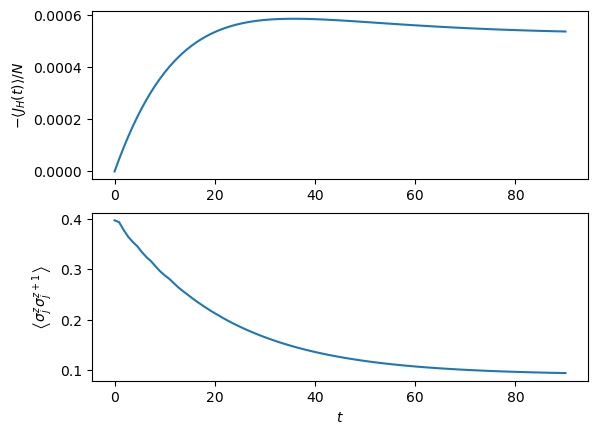

In [347]:
plt.subplot(211)
JHs = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/avg_current.txt')
plt.plot(ts, JHs)
plt.ylabel(r'$-\left< J_H(t) \right> / N$') 
plt.savefig(f"results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/avg_current.pdf")


plt.subplot(212)
spin_corr = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/spin_neighbor_correlation.txt')
plt.plot(ts, spin_corr)
plt.xlabel(r'$t$')
plt.ylabel(r'$\left< \sigma_j^z \sigma_j^{z+1} \right>$')
plt.savefig("results/time_dependent_GGE/heisenberg_spins/first_try/observables_exact.pdf")

## GGE evolution


Compute


In [ ]:
F = lambda t, s: force(s, Cs)

sol = solve_ivp(F, [tmin, tmax], lambdas_0, t_eval=t_eval)

all_params = np.vstack([sol.t, sol.y]).T
np.savetxt("results/time_dependent_GGE/heisenberg_spins/first_try/time_dependent_params.txt", all_params)

C:\Users\antho\AppData\Local\Temp\ipykernel_10196\2995203031.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  vect[j] = scp.sparse.csr_matrix.trace(conserved_quantities[j] @ lindblad_non_unitary(rho_GGE, EPSILON, GAMMA, J, N))
C:\Users\antho\AppData\Local\Temp\ipykernel_10196\2995203031.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  chi_mat[i, j] = avg_GGE(lagr, conserved_quantities, conserved_quantities[i] @ conserved_quantities[j]) \


### Observables


In [338]:
time_dependent_params = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/first_try/time_dependent_params.txt", unpack=True)
t_eval = time_dependent_params[0]
lagr = time_dependent_params[1:]


Compute


In [339]:
# Heat current
Y = []
for i, t in enumerate(t_eval) :
    avg_current = avg_GGE(lagr.T[i], Cs, -Jh(N, J)) / N
    Y.append(avg_current)

np.savetxt("results/time_dependent_GGE/heisenberg_spins/first_try/avg_current.txt", np.vstack([t_eval, np.array(Y)]).T.real)


# spin neighbor correlation
j = 3

Y = []
for i, t in enumerate(t_eval) :
    sz_j = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{j}.npz')
    sz_jp1 = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/sz_k_{j+1}.npz')

    avg_corr = avg_GGE(lagr.T[i], Cs, sz_j @ sz_jp1) 
    Y.append(-4 * avg_corr) # factor 4 because of the normalization of the spin operators

np.savetxt("results/time_dependent_GGE/heisenberg_spins/first_try/spin_neighbor_correlation.txt", np.vstack([t_eval, np.array(Y)]).T.real)



Plot


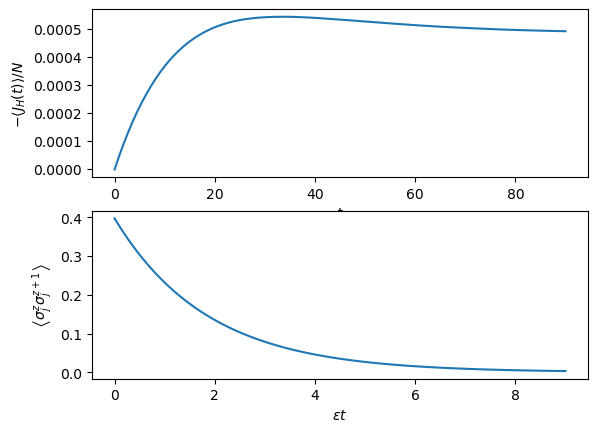

In [344]:
plt.subplot(211)
t_eval, Y = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/first_try/avg_current.txt", unpack=True)

plt.plot(t_eval, Y, label='GGE')
plt.xlabel(r'$t$')
plt.ylabel(r'$-\left< J_H(t) \right> / N$') 


plt.subplot(212)
t_eval, Y = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/first_try/spin_neighbor_correlation.txt", unpack=True)

plt.plot(EPSILON * t_eval, Y)
plt.xlabel(r'$\epsilon t$')
plt.ylabel(r'$\left< \sigma_j^z \sigma_j^{z+1} \right>$')


plt.savefig("results/time_dependent_GGE/heisenberg_spins/first_try/observables_GGE.pdf")

## Comparison Exact vs GGE


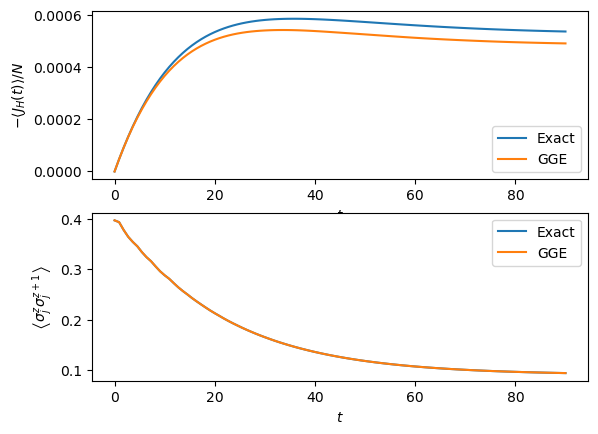

In [348]:
plt.subplot(2, 1, 1)

t_eval, Y = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/first_try/avg_current.txt", unpack=True)
ts = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/ts.txt')
JHs_exact = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/avg_current.txt')

plt.plot(ts, JHs_exact, label='Exact')
plt.plot(t_eval, Y, label='GGE')
plt.xlabel(r'$t$')
plt.ylabel(r'$-\left< J_H(t) \right> / N$') 
plt.legend()
plt.savefig("results/time_dependent_GGE/heisenberg_spins/first_try/avg_current.pdf")



plt.subplot(2, 1, 2)
t_eval, Y = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/first_try/spin_neighbor_correlation.txt", unpack=True)
Y = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/spin_neighbor_correlation.txt')
ts = np.loadtxt(f'results/time_dependent_GGE/heisenberg_spins/sol_exact/N_{N}/ts.txt')

plt.plot(ts, Y, label='Exact')
plt.plot(t_eval, Y, label='GGE')
plt.xlabel(r'$t$')
plt.ylabel(r'$\left< \sigma_j^z \sigma_j^{z+1} \right>$')
plt.legend()
plt.savefig("results/time_dependent_GGE/heisenberg_spins/first_try/observables_exact_VS_GGE.pdf")
